In [58]:
import numpy as np
import matplotlib.pyplot as plt
vec_a1 = 1
vec_a2 = 1
vec_a3 = 1
n = 1000
U = np.random.rand(n)
X = np.where(U < 0.5,
             -1 + np.sqrt(2 * U),
             1 - np.sqrt(2 * (1 - U)))

desired_var = 0.1
current_var = np.var(X)
scale_factor = np.sqrt(desired_var / current_var)
noise = np.random.normal(0, np.sqrt(desired_var), n)

rows = []
y = []
uk1 = 0
uk2 = 0
for i in range(n):
    
    value = vec_a1 * U[i] + vec_a2 * uk1 + vec_a3 * uk2 + noise[i]
    y.append(value)
    rows.append([U[i], uk1, uk2])
    uk2 = uk1
    uk1 = U[i]

y = np.array(y).reshape(-1, 1)
u = np.array(rows)
u_T = u.T
A = np.linalg.inv(u_T @ u) @ u_T @ y

print(A)

[[1.02018479]
 [0.99392184]
 [0.98881658]]


=== Optymalizacja lambda ===
Najlepsza λ = 0.98571


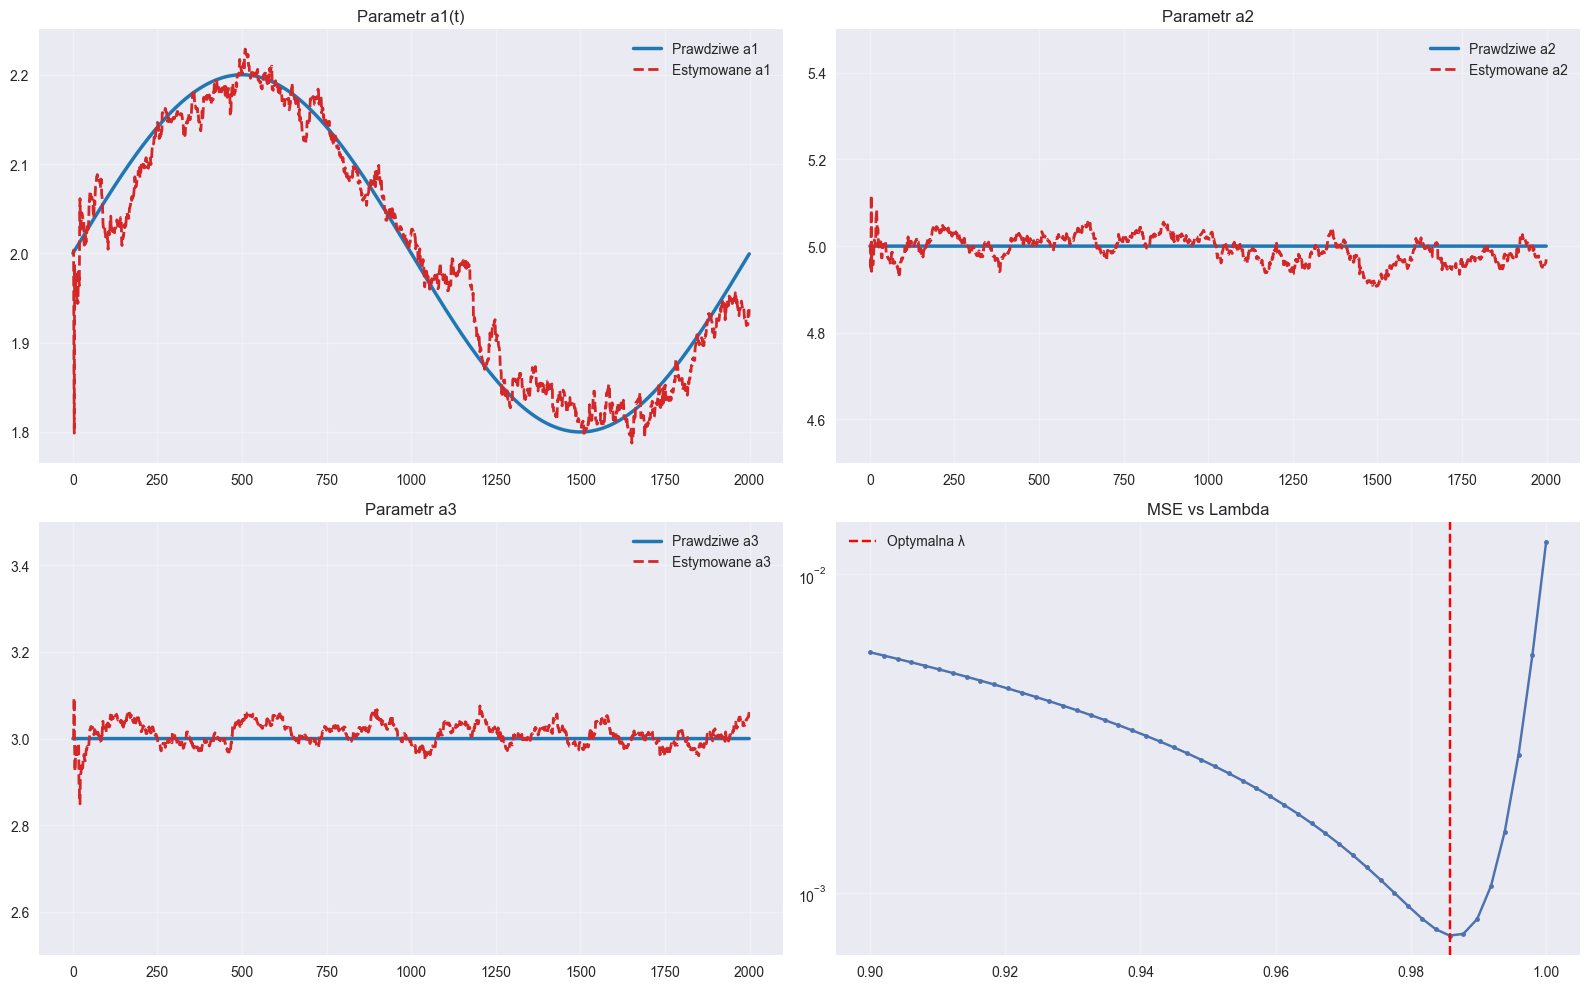

Ostatnie estymaty: a1=1.9373, a2=4.9696, a3=3.0577


In [59]:
import numpy as np
import matplotlib.pyplot as plt

# ================================================================
# 1. Parametry symulacji
# ================================================================
n = 2000
desired_var = 0.1

vec_a1_base = 2
vec_a2 = 5
vec_a3 = 3

amplitude = 0.1
period = n 


# ================================================================
# 2. Generowanie danych
# ================================================================
def generate_data(n, desired_var, vec_a1_base, vec_a2, vec_a3, amplitude, period):
    U = np.random.randn(n)
    noise = np.random.normal(0, np.sqrt(desired_var), n)

    y = np.zeros(n)
    u_hist = np.zeros(n)

    uk1 = 0.0
    uk2 = 0.0

    a1_true_history = np.zeros(n)

    for i in range(n):
        a1_i = vec_a1_base * (1 + amplitude * np.sin(2 * np.pi * i / period))
        a1_true_history[i] = a1_i

        y[i] = a1_i * U[i] + vec_a2 * uk1 + vec_a3 * uk2 + noise[i]

        u_hist[i] = U[i]
        uk2 = uk1
        uk1 = U[i]

    A_true = np.column_stack([
        a1_true_history,
        np.full(n, vec_a2),
        np.full(n, vec_a3)
    ])

    return y, u_hist, A_true


# ================================================================
# 3. RLS-FF (Zgodnie ze wzorami ze zdjęcia)
# ================================================================
def rls_ff_algorithm(y, u_hist, lambda_ff, A_true_initial):
    D = 3
    n = len(y)

    # a_hat (k-1) - wektor kolumnowy
    A_hat = A_true_initial.reshape(D, 1)

    # P (k-1)
    P = 1000 * np.eye(D)
    
    A_hist = np.zeros((n, D))

    for i in range(n):
        if i < 2:
            A_hist[i] = A_hat.flatten()
            continue

        # --- Implementacja wzorów ze zdjęcia ---

        # 1. Definicja wektora regresji Phi_k (jako kolumna Dx1)
        Phi = np.array([u_hist[i], u_hist[i-1], u_hist[i-2]]).reshape(D, 1)
        y_k = y[i]

        # 2. Obliczenie P_k (Macierz kowariancji)
        # Wzór: P_k = (1/lambda) * (P_prev - (P_prev * Phi * Phi^T * P_prev) / (lambda + Phi^T * P_prev * Phi))
        
        numerator = P @ Phi @ Phi.T @ P          # Licznik ułamka we wzorze
        denominator = lambda_ff + Phi.T @ P @ Phi # Mianownik ułamka (skalar)
        
        # Aktualizacja P (P staje się teraz P_k)
        P_new = (1.0 / lambda_ff) * (P - numerator / denominator)

        # 3. Obliczenie a_hat_k (Wektor parametrów)
        # Wzór: a_hat_k = a_hat_prev + P_k * Phi * (y_k - Phi^T * a_hat_prev)
        
        prediction_error = y_k - (Phi.T @ A_hat) # (y_k - Phi^T * a^(k-1))
        
        # Uwaga: Używamy tutaj P_new (czyli P_k ze wzoru), a nie starego P
        A_hat_new = A_hat + (P_new @ Phi) @ prediction_error

        # Aktualizacja zmiennych na następny krok
        P = P_new
        A_hat = A_hat_new
        
        # Zapis historii
        A_hist[i] = A_hat.flatten()

    return A_hist


# ================================================================
# 4. Optymalizacja lambda
# ================================================================
def run_rls_ff_optimize_balanced(y, u_hist, A_true):
    lambdas = np.linspace(0.9, 0.99999, 50)
    mse_results = {}

    print("=== Optymalizacja lambda ===")

    for lam in lambdas:
        A_hist = rls_ff_algorithm(y, u_hist, lam, A_true[0])
        err = A_hist[200:] - A_true[200:]
        
        mse_total = (0.6 * np.mean(err[:, 0]**2) + 
                     0.2 * np.mean(err[:, 1]**2) + 
                     0.2 * np.mean(err[:, 2]**2))
        
        mse_results[lam] = mse_total

    best_lambda = min(mse_results, key=mse_results.get)
    print(f"Najlepsza λ = {best_lambda:.5f}")

    return best_lambda, mse_results


# ================================================================
# 5. Symulacja
# ================================================================
np.random.seed(0)

y_data, u_hist_data, A_true_data = generate_data(
    n, desired_var, vec_a1_base, vec_a2, vec_a3, amplitude, period
)

best_lambda, mse_results = run_rls_ff_optimize_balanced(
    y_data, u_hist_data, A_true_data
)

A_est = rls_ff_algorithm(y_data, u_hist_data, best_lambda, A_true_data[0])


# ================================================================
# 6. Wykresy
# ================================================================
plt.style.use("seaborn-v0_8")
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

c_true = "#1f77b4"
c_est = "#d62728"

# a1
ax = axs[0, 0]
ax.plot(A_true_data[:, 0], label="Prawdziwe a1", color=c_true, lw=2.5)
ax.plot(A_est[:, 0], label=f"Estymowane a1", ls="--", color=c_est, lw=2)
ax.set_title("Parametr a1(t)")
ax.grid(True, alpha=0.3)
ax.legend()

# a2
ax = axs[0, 1]
ax.plot([vec_a2]*n, label="Prawdziwe a2", color=c_true, lw=2.5)
ax.plot(A_est[:, 1], label="Estymowane a2", color=c_est, ls="--", lw=2)
ax.set_title("Parametr a2")
ax.set_ylim(vec_a2 - 0.5, vec_a2 + 0.5) 
ax.grid(True, alpha=0.3)
ax.legend()

# a3
ax = axs[1, 0]
ax.plot([vec_a3]*n, label="Prawdziwe a3", color=c_true, lw=2.5)
ax.plot(A_est[:, 2], label="Estymowane a3", color=c_est, ls="--", lw=2)
ax.set_title("Parametr a3")
ax.set_ylim(vec_a3 - 0.5, vec_a3 + 0.5)
ax.grid(True, alpha=0.3)
ax.legend()

# Lambda
ax = axs[1, 1]
ax.plot(list(mse_results.keys()), list(mse_results.values()), '.-')
ax.axvline(best_lambda, color='red', ls='--', label=f"Optymalna λ")
ax.set_title("MSE vs Lambda")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"Ostatnie estymaty: a1={A_est[-1,0]:.4f}, a2={A_est[-1,1]:.4f}, a3={A_est[-1,2]:.4f}")